<a href="https://colab.research.google.com/github/aishwarya071/fake_news_detection/blob/main/NLPFakeNewsDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fake News Detection


In [ ]:
pip install anvil-uplink

     |████████████████████████████████| 64 kB 2.3 MB/s 
     |████████████████████████████████| 51 kB 199 kB/s 
  Created wheel for ws4py: filename=ws4py-0.5.1-py3-none-any.whl size=45229 sha256=96dee801a75da56ba76a5122da73c8be6b655833874315e481d58d9440f96ed9
  Stored in directory: /root/.cache/pip/wheels/29/ea/7d/3410aa0aa0e4402ead9a7a97ab2214804887e0f5c2b76f0c96
Successfully built ws4py


In [ ]:
import anvil.server

anvil.server.connect("ICMTKMAF5UKXCXWPQURBH2YC-7LFORPKPK5VX53QQ")

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default environment" as SERVER


**Import required libraries**

In [ ]:
from sklearn import model_selection, preprocessing, svm,metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import  ensemble
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
import numpy, string
from keras.preprocessing import text, sequence
from sklearn.linear_model import LogisticRegression
from joblib import dump
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import re
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**load the dataset**

In [ ]:
dataframe=pd.read_csv('/content/drive/MyDrive/Malayalam_News.csv')
#dataframe=pd.read_csv('/content/drive/MyDrive/MalayalamNews.csv') csv path - aishwarya 

In [ ]:
dataframe.head()

,News,Outcome,mal_text
0,Pakistan Prime Minister Khan criticised over m...,1,കേസുകളായി യോഗത്തിൽ യോഗത്തിൽ യോഗത്തിൽ വിമർശിച്ചു.
1,"Chhattisgarh reports 2,665 fresh Covid-19 case...",1,"കഴിഞ്ഞ 24 മണിക്കൂറിനുള്ളിൽ 2,665 പുതിയ കോണിഡ് ..."
2,Read: WHO urges countries to donate 10 million...,1,വായിക്കുക: 10 ദശലക്ഷം വാക്സിൻ ഡോസുകൾ സംഭാവന ചെ...
3,WHO in talks with India about vaccine exports ...,1,വാക്സിൻ കയറ്റുമതിയെക്കുറിച്ച് ആരാണ് ഇന്ത്യയുമാ...
4,Read - Covid-19: Maharashtra CM announces nigh...,1,വായിക്കുക - കോത്ത് -1: മാർച്ച് 28 മുതൽ സംസ്ഥാന...


**Clean the Dataset**

In [ ]:
cedilla2latin = [[u'Á', u'A'], [u'á', u'a'], [u'Č', u'C'], [u'č', u'c'], [u'Š', u'S'], [u'š', u's']]
tr = dict([(a[0], a[1]) for (a) in cedilla2latin])

In [ ]:
nltk.download('stopwords')
stops = set(stopwords.words("english"))
def cleantext(string):
    text = string.lower().split()
    text = " ".join(text)
    text = re.sub(r"http(\S)+",' ',text)    
    text = re.sub(r"www(\S)+",' ',text)
    text = re.sub(r"&",' and ',text)  
    tx = text.replace('&amp',' ')
    text = re.sub(r"[^0-9a-zA-Z]+",' ',text)
    text = text.split()
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
for line in dataframe:
  line = cleantext(line)

**Analyse the dataset**

In [ ]:
dataframe.count()

News        10850
Outcome     10850
mal_text    10850
dtype: int64

In [ ]:
dataframe.shape

(10850, 3)

In [ ]:
dataframe.Outcome.value_counts()

0    9689
1    1161
Name: Outcome, dtype: int64

**Visualization Of Dataset**

Text(0.5, 1.0, 'Fake and True in train dataset')

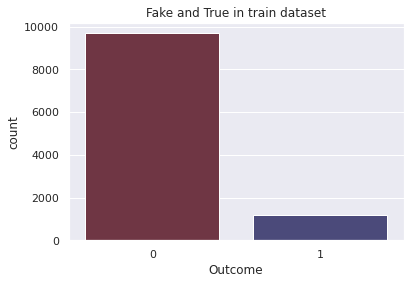

In [ ]:
sns.set(font_scale=1)
sns.countplot(x='Outcome',data=dataframe,palette='icefire_r').set_title('Fake and True in train dataset')

**Create a dataframe using News and Outcome**

In [ ]:
x = dataframe['News']
y = dataframe['Outcome']

**Split the dataset into training and validation datasets**

In [ ]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(dataframe['News'], dataframe['Outcome'])

**Label encode the target variable- Outcome**

In [ ]:
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

**Feature engineering using Word Level TF-IDF**

TF-IDF score represents the relative importance of a term in the document and the entire corpus. TF-IDF score is composed by two terms: the first computes the normalized Term Frequency (TF), the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document)

IDF(t) = log_e(Total number of documents / Number of documents with term t in it)

In [ ]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(dataframe['News'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

In [ ]:
dump(tfidf_vect, 'tfidf.pkl')

['tfidf.pkl']

**Function to train Classifier and calculate Accuracy**

In [ ]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)

    import pickle
    pickle.dump(classifier, open('kuy.pkl', 'wb'))
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, valid_y)


**SVM**

A support vector machine (SVM) is a type of deep learning algorithm that performs supervised learning for classification or regression of data groups. In AI and machine learning, supervised learning systems provide both input and desired output data, which are labeled for classification.

In [ ]:
def SVM():
  accuracy = train_model(svm.SVC(), xtrain_tfidf, train_y, xvalid_tfidf)
  print("SVM: ", accuracy)
SVM()

SVM:  0.9450792480648729


Google Translate

In [ ]:
pip install googletrans==3.1.0a0

     |████████████████████████████████| 55 kB 2.3 MB/s 
     |████████████████████████████████| 42 kB 1.3 MB/s 
     |████████████████████████████████| 1.3 MB 10.8 MB/s 
     |████████████████████████████████| 53 kB 2.0 MB/s 
     |████████████████████████████████| 65 kB 3.6 MB/s 
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16367 sha256=818da8cc4827e3c31bbb8781cdf26a0b12ad5aa4f54076f515e4dd188640a4b4
  Stored in directory: /root/.cache/pip/wheels/0c/be/fe/93a6a40ffe386e16089e44dad9018ebab9dc4cb9eb7eab65ae
Successfully built googletrans


In [ ]:
#Testing Googletrans alpha version
from googletrans import Translator

detector = Translator()

In [ ]:
tr = Translator()
inp = input("Enter a statement in malayalam >>>> ")
eng = tr.translate(inp).text
eng = eng.lower().replace('\W+'," ")

removed_stopword = []
for word in eng.split(): 
    if word not in stops:
        removed_stopword.append(word)

eng = np.array([" ".join(removed_stopword)])
eng

Enter a statement in malayalam >>>> 15 സംസ്ഥാനങ്ങളിൽ കൊവിഡ് കേസുകൾ കൂടുന്നു, ദില്ലിയിൽ കൊവിഡ് പ്രതിരോധ മാർഗരേഖ നടപ്പാക്കുന്നത് കർശനമാക്കി


array(['kovid cases rise 15 states, implementation kovid prevention guidelines tightened delhi'],
      dtype='<U86')

In [ ]:
import joblib
import time
import pandas as pd


import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

vectorizer = open("/content/tfidf.pkl", "rb")
cv = joblib.load(vectorizer)

# load Model For News Prediction
svm_model = open("/content/kuy.pkl", "rb")
clf = joblib.load(svm_model)

In [ ]:
@anvil.server.callable
def predict_fake(inp):
  tr = Translator()
  eng = tr.translate(inp).text
  eng = eng.lower().replace('\W+'," ")

  removed_stopword = []
  for word in eng.split(): 
      if word not in stops:
          removed_stopword.append(word)

  eng = np.array([" ".join(removed_stopword)])
  tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
  tfidf_vect.fit(dataframe['News'])
  X=tfidf_vect.transform(eng)

  result = clf.predict(X)
  if (result >= 0.5):
    return("Genuine")

  else:
    return("Fake")


In [ ]:
anvil.server.wait_forever()